In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
samples_base_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6"
cut              = "lowen_looseVBS"
samples_version  = "v7"
model_version    = "v8"

samples_dir = os.path.join(samples_base_dir, cut, "samples", samples_version)

model_dir   = os.path.join(samples_base_dir, cut, "models",  model_version)
import os 
os.makedirs(model_dir, exist_ok=True)


In [3]:
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [4]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

Using TensorFlow backend.


'mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 
'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 
'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 
'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww

In [6]:
import yaml
yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
print(type(yaml_vars), yaml_vars)
cols = yaml_vars

<class 'list'> ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww']


In [7]:
X_sig = signal[cols].values
X_bkg = bkg[cols].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values

In [8]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

vjet_0_eta


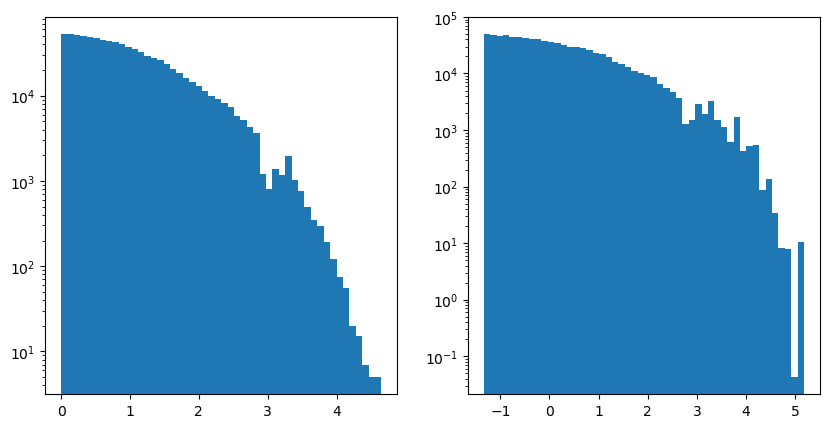

In [10]:
i = 10
print(cols[i])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
ax1.hist(X[:,i], bins=50)
ax1.set_yscale("log")
ax2.hist(X_scaled[:,i], weights=W, bins=50)
plt.yscale("log")

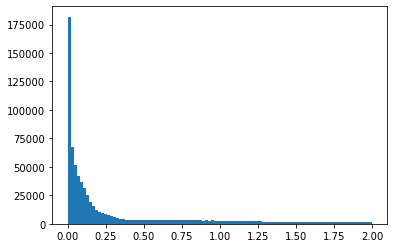

In [11]:
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing
Let's give 25% to validation (validation during training + test). 
The validation is then split in 50%-50% for training validation and final result

In [12]:
X_train, X_temp, y_train, y_temp, W_train, W_temp = train_test_split(X_scaled, Y,      W,      test_size=0.4)
X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=0.1)

In [13]:
print("Training dataset: ", X_train.shape)

Training dataset:  (505824, 32)


Create generators to balance signal and background

In [14]:
training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=1024, sampler=RandomOverSampler())

## Keras model

In [15]:
# import numpy as np
# from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import roc_auc_score, roc_curve

## callbacks
# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.auc = []
        self.dnn_score_plot = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
        clear_output(wait=True)

        # ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, "o-", label="loss")
        ax1.plot(self.x, self.val_losses, "o-", label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, "o-", label="accuracy")
        ax2.plot(self.x, self.val_acc, "o-", label="validation accuracy")
        ax2.legend()
        
        pred = model.predict(X_test)
        auc_w = roc_auc_score(y_test,pred, sample_weight=W_test)
        self.auc.append(auc_w)
        #fpW, tpW, thW = roc_curve(y_test, pred, sample_weight=W_test)
        #ax3.plot(fpW, tpW, label=f"ROC W (AUC={auc_w:.3f})", color="red")
        #ax3.legend(loc=(0.4, 0.5), fontsize="large")
        ax3.plot(self.x, self.auc, "o-")

        h1 = ax4.hist(pred[y_test==0],weights=W_test[y_test==0], bins=40,density=True, label="false", histtype="step")
        h2 = ax4.hist(pred[y_test==1],weights=W_test[y_test==1], bins=40, density=True, label="true", histtype="step")
        ax4.legend()        
        
        self.dnn_score_plot.append((h1,h2))
        
        plt.show();
        
plot_losses = PlotLosses()

In [17]:
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.2))
#model.add(Dense(50, activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(30, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

W0129 14:55:08.512085 140401592502080 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0129 14:55:08.516657 140401592502080 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0129 14:55:08.543753 140401592502080 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0129 14:55:08.555788 140401592502080 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96pyt

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                1650      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 3,211
Trainable params: 3,211
Non-trainable params: 0
_________________________________________________________________


In [18]:
## callbacks

# auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
#                     verbose=1, save_best_only=True, save_weights_only=False, 
#                     mode='auto', period=5)
#
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
#                             patience=10, verbose=1)

In [19]:
## In case you do not want to use the generators

# history = model.fit(
#             X_train,y_train, 
#             sample_weight=W_train, 
#             epochs=50,
#             validation_data = (X_val, y_val, W_val),
#             batch_size=1024,
#             shuffle=True 
#             )

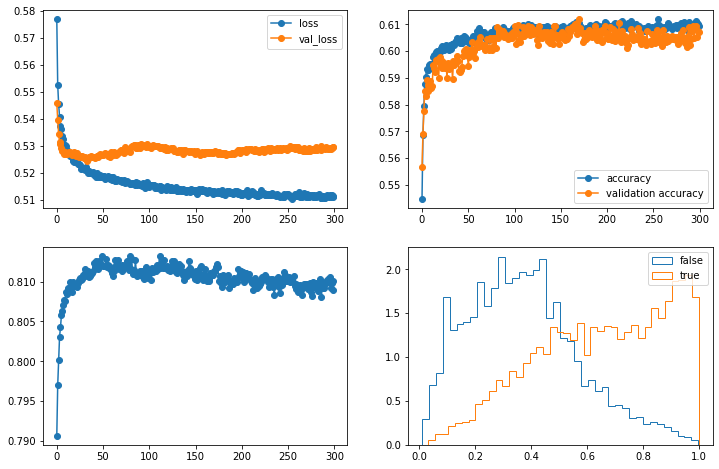

In [20]:
history = model.fit_generator(
            training_generator, 
            epochs=300,
            #initial_epoch=200,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks=[plot_losses],
            #callbacks = [], 
            )

(array([0.0670329 , 0.09917765, 0.18595126, 0.12553186, 0.33584889,
        0.23642381, 0.39683364, 0.49215185, 0.57221538, 0.49400545,
        0.50473588, 0.66419061, 0.8231907 , 1.07876062, 1.02978572,
        0.96696776, 0.97266016, 1.04369428, 1.11520188, 1.20403788,
        1.35354903, 1.12643606, 1.23696267, 1.12494722, 1.2281256 ,
        1.3556441 , 1.07172269, 1.23588346, 1.17827736, 1.36386358,
        1.2522841 , 1.27183853, 1.29744659, 1.61170076, 1.67055993,
        1.67116355, 1.77657707, 2.10020837, 2.19039218, 2.19446145]),
 array([0.04098627, 0.06495534, 0.0889244 , 0.11289346, 0.13686253,
        0.1608316 , 0.18480065, 0.20876972, 0.2327388 , 0.25670785,
        0.28067693, 0.304646  , 0.32861507, 0.35258412, 0.37655318,
        0.40052226, 0.42449132, 0.44846037, 0.47242945, 0.4963985 ,
        0.52036756, 0.5443366 , 0.56830573, 0.5922748 , 0.61624384,
        0.6402129 , 0.66418195, 0.68815106, 0.7121201 , 0.73608917,
        0.7600582 , 0.7840273 , 0.8079964 , 0.

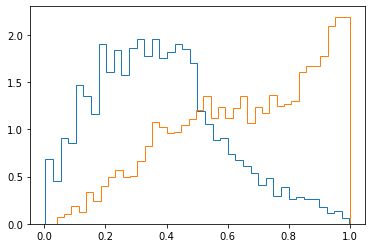

In [47]:
n = 250
plt.hist(plot_losses.dnn_score_plot[n][0][1][:-1], bins=plot_losses.dnn_score_plot[n][0][1], weights=plot_losses.dnn_score_plot[n][0][0], histtype="step")
plt.hist(plot_losses.dnn_score_plot[n][1][1][:-1], bins=plot_losses.dnn_score_plot[n][1][1], weights=plot_losses.dnn_score_plot[n][1][0], histtype="step")

In [23]:
model.save(f"{model_dir}/model.h5")

>>> Computing AUC...


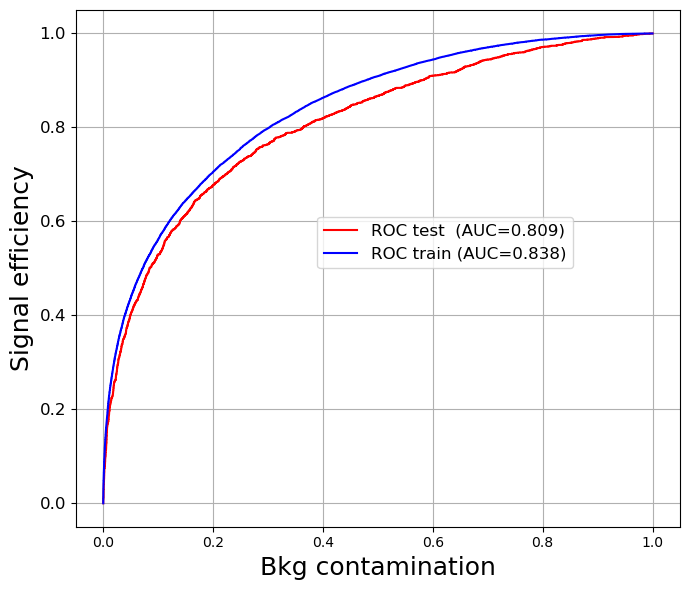

In [24]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred_test  = model.predict(X_test,  batch_size=2048)
pred_train = model.predict(X_train, batch_size=2048)
auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test , sample_weight=W_test)
fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train, sample_weight=W_train)
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

In [26]:
max(plot_losses.auc)

0.8132172367069199

In [38]:
#r = model.evaluate_generator(training_generator, steps=1000)
r = model.evaluate_generator(validation_generator, steps=1000)


In [39]:
print(model.metrics_names, r)

['loss', 'acc'] [0.5296341855909091, 0.6071268029807158]


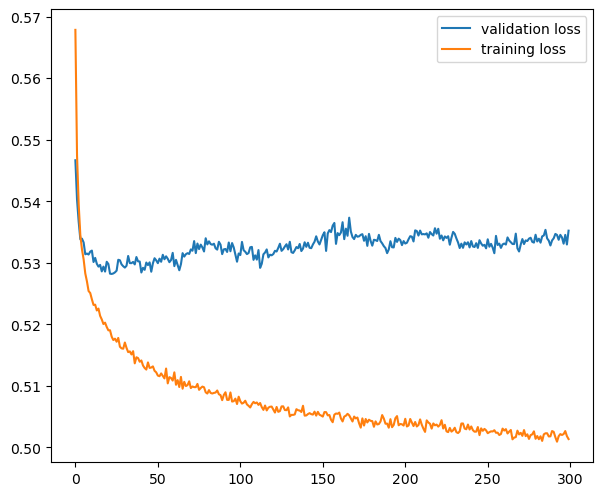

In [21]:
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
ax.plot(history.epoch, history.history["val_loss"], label="validation loss")
ax.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

Ks_2sampResult(statistic=0.01292586488240996, pvalue=0.41918542776483037)

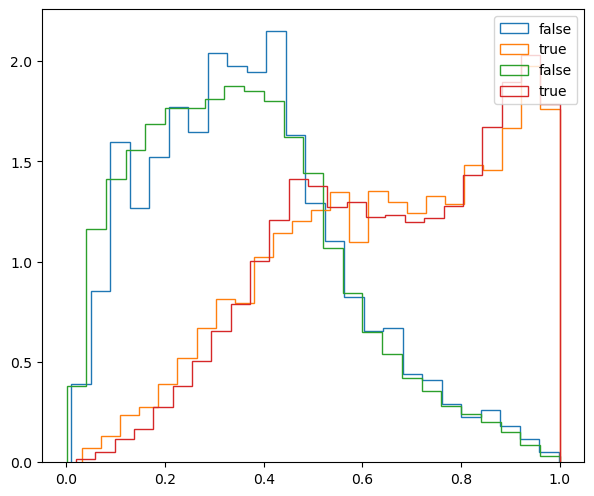

In [77]:
results_test  = model.predict(X_test, batch_size=2048)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results_test[y_test==0],weights=W_test[y_test==0], bins=25, density=True, label="false", histtype="step")
plt.hist(results_test[y_test==1],weights=W_test[y_test==1], bins=25, density=True, label="true", histtype="step")
results_train = model.predict(X_train, batch_size=2048)
plt.hist(results_train[y_train==0],weights=W_train[y_train==0], bins=25, density=True, label="false", histtype="step")
plt.hist(results_train[y_train==1],weights=W_train[y_train==1], bins=25, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

# 
# 

#results_train[y_train==1]
rtest  = [x[0] for x in results_test[y_test==1]]
rtrain = [x[0] for x in results_train[y_train==1]]

from scipy import stats
scipy.stats.ks_2samp(rtrain, rtest)

In [56]:
results_test[y_test==1].shape

(4959, 1)

## Evaluation by sample

In [23]:
bkg["y"] = model.predict(scaler.transform(bkg[cols].values), batch_size=2048)

In [24]:
signal["y"] = model.predict(scaler.transform(signal[cols].values), batch_size=2048)

In [25]:
wjets = bkg[bkg["sample_name"] == "Wjets"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

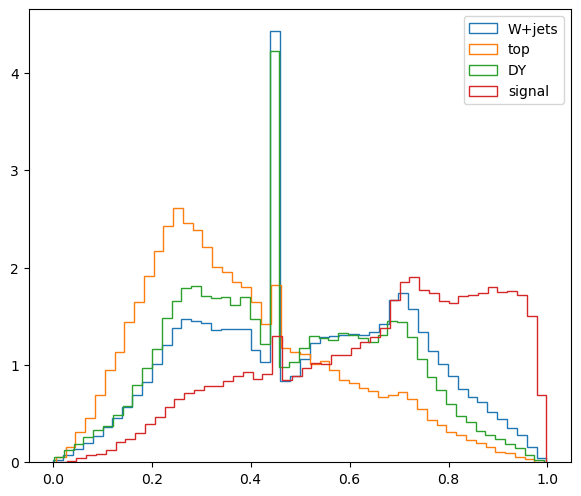

In [26]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets"]["y"], bins=50, density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50, density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

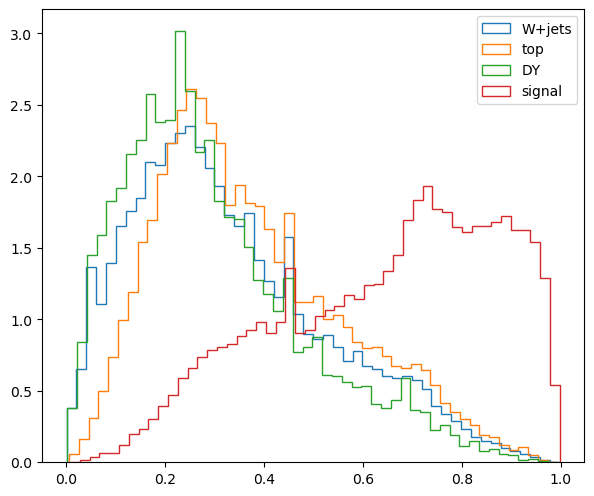

In [27]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.weight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.weight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.weight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.weight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()